In [11]:
import cProfile
import os
import pstats
import sys
from pstats import SortKey

import numpy as np
import pandas as pd
from river.decomposition import OnlineDMDwC
from river.preprocessing import Hankelizer
from tqdm import tqdm

sys.path.append("../")

from functions.chdsubid import (
    SubIDChangeDetector,
    get_default_rank,
)
from functions.datasets import load_cats
from functions.metrics import chp_score
from functions.plot import plot_chd
from functions.preprocessing import hankel
from functions.rolling import Rolling

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Read data
df = load_cats(resample_s=60)
df.index = pd.to_datetime(df.index)
U = df[["aimp", "amud", "adbr", "adfl"]]
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
    ]
]
Y_true = df.pop("y")
Y_cat = df.pop("category")

In [14]:
window_size: int = 60 * 24
# Base size
ref_size = 60 * 5
test_size = 60 * 5
# If window_size is not very large, then take half
h_max = int(60 / X.shape[1])
h_reco = 60 * 4
if h_reco < h_max:
    hn = h_reco
    hu = h_reco
    step = 1
else:
    hn = h_max
    hu = h_max
    step = (h_reco) // h_max
# Optimal low-rank representation of signal with unknown noise variance
p = min(len(X.columns), get_default_rank(hankel(X[:window_size], hn, step)))
print(f"Optimal rank for states is: {p}")
q = min(len(U.columns), get_default_rank(hankel(U[:window_size], hu, step)))
print(f"Optimal rank for inputs is: {q}")

Optimal rank for states is: 10
Optimal rank for inputs is: 4


Snapshots processed: 100%|██████████| 83274/83274 [28:55<00:00, 47.99it/s]   
/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_25251/2250144084.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(fig_name)


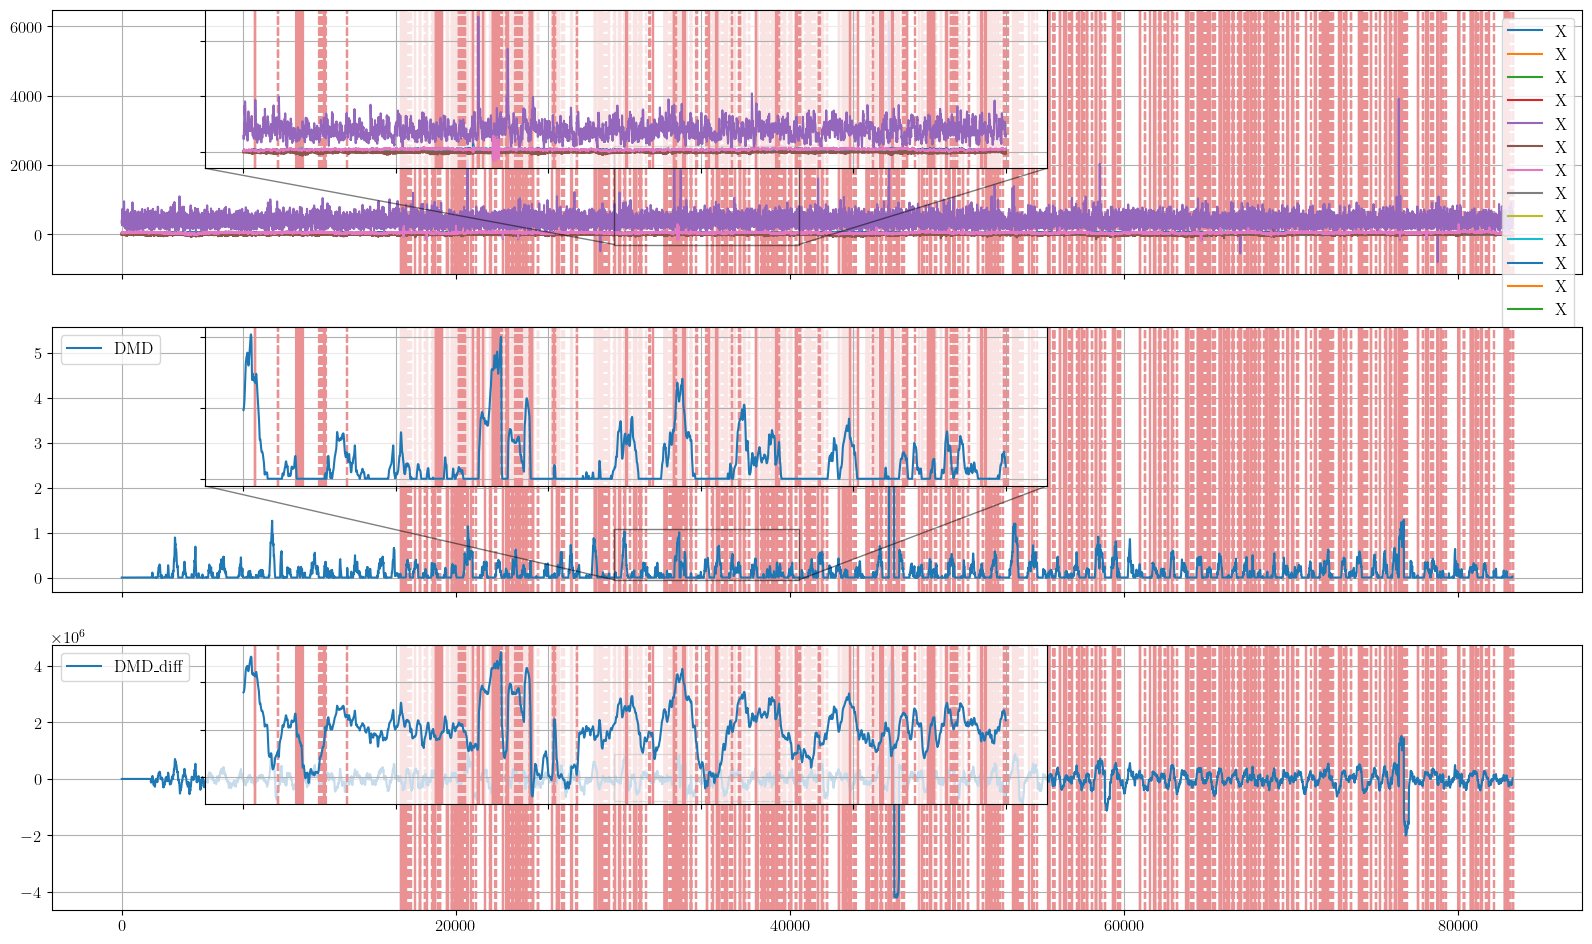

In [5]:
# [donotremove]
# TODO: enable hankelization of us on the fly
U_ = pd.DataFrame(hankel(U, hn=hu))

# Initialize Hankelizer
hankelizer = Hankelizer(hn)

# Initialize Transformer
init_size = window_size
odmd = Rolling(
    OnlineDMDwC(
        p=p,
        q=q,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-1,
    ),
    init_size + 1,
)

# Initialize Change-Point Detector
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
# scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn * X.shape[1], p), dtype=complex)

# Run pipeline
for i, (x, u) in tqdm(
    enumerate(
        zip(
            X.to_dict(orient="records"),
            U_.to_dict(orient="records"),
        )
    ),
    total=len(X),
    mininterval=1.0,
    desc="Snapshots processed",
):
    scores_dmd[i] = pipeline_dmd.score_one(x)
    dist[i, :] = subid_dmd.distances
    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

    pipeline_dmd.learn_one(x, **{"u": u})

# Plot results
X_ = df.values
Y_ = Y_true.values
fig, axs = plot_chd(
    [X_, scores_dmd.real, scores_dmd_diff.real],
    np.where(Y_ == 1)[0],
    labels=["X", "DMD", "DMD_diff", "SVD"],
    ids_in_start=[30000],
    ids_in_end=[40000],
    grace_period=test_size,
)
fig_name = (
    f"results/.cats/cats-chd_p{p}_q{q}-l{init_size}_b{ref_size}_t{test_size}"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-hx{hn}-hu{hu}-imag.pdf"
)
fig.set_size_inches(18, 10)  # Set the size of the figure
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)

In [9]:
pred_shift = 1
y_true = pd.Series(Y_, index=df.index)
y_true_cp = y_true.diff().abs().fillna(0.0)

In [10]:
experiments: dict[str, pd.Series] = {
    "Perfect detector": y_true,
    "Random detector": pd.Series(
        np.random.randint(2, size=df.shape[0]), index=df.index
    ),
    "Null detector": pd.Series(np.zeros(df.shape[0]), index=df.index),
    "Always positive": pd.Series(np.ones(df.shape[0]), index=df.index),
    "Online DMD (t=0)": pd.Series(scores_dmd > 0.0, index=df.index),
    "Online DMD (t=0.5)": pd.Series(scores_dmd > 0.5, index=df.index),
    "Online DMD": pd.Series(scores_dmd > 0.25, index=df.index),
}

window_params = {
    "valid": {
        "window_width": f"{test_size}min",
        "anomaly_window_destination": "righter",
    },
}

metrics = [
    "F1",
    "FAR",
    "MAR",
    "Delay",
    "TP",
    "FN",
    "FP",
    "Standard",
    "LowFP",
    "LowFN",
]

df_res = pd.DataFrame(
    columns=[m for m in metrics],
    index=list(experiments.keys()),
)

for name, po in experiments.items():
    pc = po.astype(int).diff().abs().fillna(0.0)
    res = {}
    for window_name, kwargs in window_params.items():
        binary = chp_score(
            y_true,
            po,
            metric="binary",
        )
        add = chp_score(
            y_true_cp,
            pc,
            metric="average_time",
            window_width=kwargs["window_width"],
            anomaly_window_destination=kwargs["anomaly_window_destination"],
        )
        nab = chp_score(
            y_true_cp,
            pc,
            metric="nab",
            window_width=kwargs["window_width"],
            anomaly_window_destination=kwargs["anomaly_window_destination"],
        )
        res_ = dict(zip(["F1", "FAR", "MAR"], binary))
        res_.update(dict(zip(["Delay", "FN", "FP", "TP"], add)))
        res_.update(nab)
        res_ = {k: v for k, v in res_.items()}
        res.update(res_)
    df_res.loc[name] = res

df_res

/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,F1 (valid),FAR (valid),MAR (valid),Delay (valid),TP (valid),FN (valid),FP (valid),Standard (valid),LowFP (valid),LowFN (valid)
Perfect detector,1.0,0.0,0.0,0 days 00:21:53.233082706,398,265,0,30.21,29.89,31.28
Random detector,0.07,49.7,49.59,0 days 00:01:06.666666666,398,2,20243,-182.46,-462.42,-88.47
Null detector,0.0,0.0,100.0,NaN,398.0,398.0,0.0,0.0,0.0,0.0
Always positive,0.07,100.0,0.0,NaN,398.0,398.0,0.0,0.0,0.0,0.0
Online DMD (t=0),0.07,48.77,48.52,0 days 01:17:45.789473684,398,246,305,25.66,20.62,29.84
Online DMD (t=0.5),0.08,4.38,91.46,0 days 01:40:16.744186046,398,355,27,7.24,6.55,8.43
Online DMD,0.08,15.67,79.3,0 days 01:15:07.500000,398,294,161,17.84,15.01,20.6


# Time Profiling to Reveal the Main Bottlenecks

In [ ]:
import datetime


def simulate():
    # Initialize Hankelizer
    U_ = pd.DataFrame(hankel(U, hn=hu))

    # Initialize Hankelizer
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    init_size = window_size
    odmd = Rolling(
        OnlineDMDwC(
            p=p,
            q=q,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    # Prepare arrays for storing results
    scores_dmd = np.zeros(X.shape[0], dtype=float)
    # Run pipeline
    for i, (x, u) in tqdm(
        enumerate(
            zip(
                X.to_dict(orient="records"),
                U_.to_dict(orient="records"),
            )
        ),
        total=len(X),
        mininterval=10.0,
        desc="Snapshots processed",
    ):
        scores_dmd[i] = pipeline_dmd.score_one(x)

        pipeline_dmd.learn_one(x, **{"u": u})


cProfile.run(
    "simulate()",
    f".stats_{datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H%M%S")}",
)

Snapshots processed: 100%|██████████| 83274/83274 [30:26<00:00, 45.60it/s]


In [ ]:
perf_stats = pstats.Stats(".stats_pd_2024-05-17_225443")
perf_stats.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

Sat May 18 08:25:42 2024    .stats_pd_2024-05-17_225443

         602901271 function calls (588544191 primitive calls) in 1859.799 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  369/207    4.293    0.012 1875.361    9.060 threading.py:323(wait)
      2/1    0.000    0.000 1855.906 1855.906 {built-in method builtins.exec}
        1    0.059    0.059 1855.906 1855.906 <string>:1(<module>)
        1    9.610    9.610 1851.511 1851.511 2430896644.py:4(simulate)
    83274    1.009    0.000 1120.741    0.013 pipeline.py:418(learn_one)
    83274    0.182    0.000 1116.805    0.013 chdsubid.py:245(learn_one)
    83274    0.389    0.000 1116.606    0.013 chdsubid.py:309(update)
    82974    0.994    0.000 1115.934    0.013 rolling.py:80(update)
   163945  131.676    0.001 1029.830    0.006 odmd.py:286(_truncate_w_svd)
    82974   22.103    0.000  846.359    0.010 odmd.py:970(update)
    81973    3.465    0.000  804.141    0.010

In [ ]:
perf_stats = pstats.Stats(".stats_new")
perf_stats.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()

Tue Apr  9 08:10:09 2024    .stats_new

         311968672 function calls (305153401 primitive calls) in 713.911 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  713.911  713.911 {built-in method builtins.exec}
        1    0.021    0.021  713.911  713.911 <string>:1(<module>)
        1    0.115    0.115  713.891  713.891 1745487788.py:4(simulate)
     5000    0.105    0.000  712.637    0.143 pipeline.py:418(learn_one)
     5000    0.534    0.000  709.902    0.142 chdsubid.py:137(learn_one)
     5000    2.063    0.000  709.369    0.142 chdsubid.py:93(update)
    27000    0.388    0.000  551.492    0.020 frame.py:683(__init__)
     4500    3.011    0.001  452.800    0.101 construction.py:506(nested_data_to_arrays)
     4500    0.129    0.000  449.668    0.100 construction.py:793(to_arrays)
     4500  286.930    0.064  333.052    0.074 construction.py:891(_list_of_dict_to_arrays)
     4500    2.1